# Modeling the Spectral DefocusCam
This notebook demonstrates the following:
* how to model DefocusCam's hyperspectral measurements
* how to train a neural network to recover hyperspectral images from these measurements
* how to use and validate the trained model

We will begin by importing a number of necessary libraries, as well as setting up the work-space:

In [18]:
#main libraries:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.io 
import lpips
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, glob, cv2

# packages needed for making a dataset: 
from torch.utils.data import DataLoader
from torchvision import transforms

from diffuser_utils import *
import spectral_diffusercam_utils.helper_functions as helper
import dataset as ds
import models.spectral_model as sm
import models.machinelearning_forward as fm
import dataset_helper_functions.read_pca_data as rpca
import csv

# packages needed for training the network:
from datetime import date, datetime

import sys
sys.path.append("..")

from models.unet import Unet
import models.unet3d as Unet3d

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


os.environ['CUDA_LAUNCH_BLOCKING'] = '1' 
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3" #choose the number of gpu that's free. It goes from 0-3

device = 'cuda:0'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting Up Our Datasets
First, let's acquire and format our data to be used by the neural network. These consist of open source hyperspectral images from various research datasets.

In [2]:
fruitset_pca = glob.glob('../DefocusCamData/sample_data/fruitdata/pca/*.mat')
fruitset_cspace = glob.glob('../DefocusCamData/sample_data/fruitdata/cspaces/*.mat')
apple = glob.glob('../DefocusCamData/sample_data/fruit/*.mat')
all_files_summer = glob.glob('/home/kyanny_waller/summerResearch/CZ_hsdb/*.mat')[6:]
val_files_summer = glob.glob('/home/kyanny_waller/summerResearch/CZ_hsdb/*.mat')[0:6]
paviaU = glob.glob('../DefocusCamData/sample_data/paviadata/Pavia*.mat')

# load pavia images (validation set)
pavia_test_data = ds.SpectralDataset(paviaU, transforms.Compose([ds.subImageRand(),
                                                                   ds.chooseSpectralBands(interp = True), 
                                                                   ds.Normalize(), 
                                                                   ds.toTensor()]),
                                                                   tag = ['paviaU', 'pavia'])
#load giessen images
fruit_train_data = ds.SpectralDataset(fruitset_pca, transforms.Compose([ds.readCompressed(),
                                                                       ds.Resize(),
                                                                       ds.chooseSpectralBands(),
                                                                       ds.RandFlip(), 
                                                                       ds.Normalize(), 
                                                                       ds.toTensor()]))
#load harvard images
summer_data = ds.SpectralDataset(all_files_summer, transforms.Compose([ds.Resize(), 
                                                                       ds.chooseSpectralBands(),
                                                                       ds.RandFlip(),
                                                                       ds.Normalize(),
                                                                       ds.toTensor()]), tag = 'ref')
#we will load a subset of these harvard images as validation
val_data = ds.SpectralDataset(val_files_summer, transforms.Compose([ds.Resize(), 
                                                                       ds.chooseSpectralBands(),
                                                                       ds.RandFlip(),
                                                                       ds.Normalize(),
                                                                       ds.toTensor()]), tag = 'ref')
# wrap training sets
train_data = ds.Wrapper([summer_data, fruit_train_data])

#make dataloaders for pytorch
test_dataloader = DataLoader(pavia_test_data, batch_size = 1, shuffle = True)
train_dataloader = DataLoader(train_data, batch_size = 1, shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = 1, shuffle = True)


In [3]:
#make sure that our dataloaders are actually loading data
print(f'Number of: \n\t training samples: {len(train_dataloader)} \n\t testing samples {len(test_dataloader)} \n\t validation samples {len(val_dataloader)}')

Number of: 
	 training samples: 86 
	 testing samples 3 
	 validation samples 6


Note that although we only have 3 testing samples, the pavia samples are *much* larger images, from which we will randomly draw 256x256 tiles. So, our test set is effectively larger than shown here.

We can look at some of our hyperspectral images to demonstrate their form:
* x direction: spatial
* y direction: spatial
* z direction: spectral

The code below displays 2d slices of the z or $\lambda$ axis at intervals of 5.
<br> <br>
Notice how the slices appear to have different intensities at different parts of the image. This is because each slice represents the intensity of a small wavelength band. For 30-channel hyperspectral images, we divide the visible spectrum into 30 ~10nm segments.

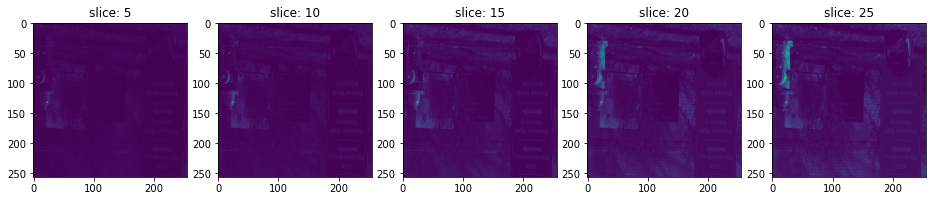

In [4]:
spectral_slices = (5, 10, 15, 20, 25) #any set of integers between 0 and 30 disclusive

for i, sample in enumerate(train_dataloader): 
    if i == 0:
        image_np = (sample['image'][0].cpu().numpy()) #convert the tensor to a numpy array
        fig, ax = plt.subplots(1, len(spectral_slices), figsize = (16, 4))
        for j in range(len(spectral_slices)):
            ax[j].imshow(image_np[spectral_slices[j]])
            ax[j].set_title(f'slice: {spectral_slices[j]}')
        plt.show()
        break


## Defining the Forward Model
Next let's define our <u> forward model </u> from the models.machinelearning_forward package. <br> Our forward model handles <u>simulating the measurements </u> (defocus) and performing some <u>signals processing </u>on them before they enter the reconstructive network. <br> <br> The code in the fm model class uses PyTorch to:
* generate the point spread functions of our multiple blur kernels
* simulate the blurred measurements using these point spread functions
* process these images based upon the known forward model's function 

The model returns *approximate* hyperspectral volumes for each measurement.


In [5]:
mask = load_mask()
num_inputs_simult = 6 #number of measurements to simulate
blur_type = 'symmetric'
optimize_blur = False
forward_model = fm.Forward_Model(mask, num_ims = num_inputs_simult,
                                 blur_type = blur_type, optimize_blur = optimize_blur)

optimize blur False


The important methods in the forward model are Hfor and Hadj. 
* Hfor:
```python
    def Hfor(self):
        H = fft_psf(self, self.psfs)
        X = self.Xi
        out = torch.fft.ifft2(H*X).real
        output = self.mask_var * crop_forward(self,  out)
        output = torch.sum(output, 2)
        return output
```
This takes in our stacked measurements (self.Xi) and convolves them with the their corresponding psfs.
<br> <br>
* Hadj
```python
    def Hadj(self, sim_meas):
        Hconj = torch.conj(fft_psf(self, self.psfs))
        sm = pad_zeros_torch(self, sim_meas.unsqueeze(2) * self.mask_var)
        SM = fft_im(sm)[0].unsqueeze(1)
        adj_meas = torch.fft.ifft2(Hconj*SM).real
        return adj_meas
```
This calculates the adjoint of our simulated measurements, which is akin to attempting an approximate inverse of the non-invertible aprox-linear transformation of the lens. <br> <br>

*More about the theory behind the adjoint can be found at https://waller-lab.github.io/DiffuserCam/tutorial/algorithm_guide.pdf*

Now we can look at the results of our forward model on an example tensor image. <br> <br>
The following code loads an image tensor in and calls the forward model on it. Notice how we are producing multiple measurements, sharp and blurry, and how the adjoint separates them into their spectral channels (these are condensed by use of np.mean() for sake of space).

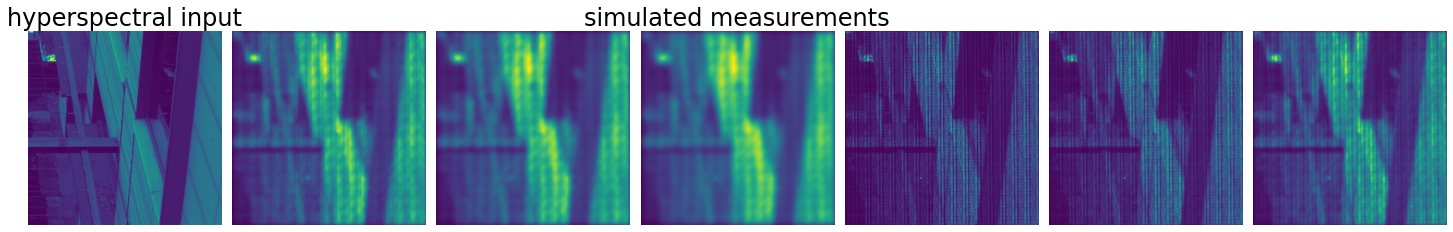

In [6]:
image_tensor1 = None
for i, sample in enumerate(train_dataloader): 
    if i == 0:
        image_tensor1 = sample['image']
    elif i == 1:
        image_tensor2 = sample['image']
        image_tensor = torch.stack((image_tensor1.to(device), image_tensor2.to(device)), dim = 1)[0]
        simulated_meas = forward_model(image_tensor.to(device))

        spectral_slices = (5, 10, 15, 20, 25)
        rows = 1
        image_np = (image_tensor[0].cpu().numpy()).transpose(1,2,0)
        fig, ax = plt.subplots(1,1 + num_inputs_simult, figsize = (20, 5))

        ax[0].imshow(np.mean(image_np,-1)); 
        ax[0].axis('off')
        ax[0].set_title('hyperspectral input', fontsize=24)

        for j in range(1,num_inputs_simult+1):
            ax[j].imshow(np.mean(simulated_meas[0].detach().cpu().numpy()[j-1], 0))
            ax[j].axis('off')
            if j == 3:
                ax[j].set_title('simulated measurements', fontsize=24)
        plt.tight_layout()
        plt.show()
        break

## Defining the Reconstructive Model
Now let's define our <u> reconstructive model </u> from the models.Unet3d package. <br> We will use a U-Net (https://arxiv.org/abs/1505.04597) modified to handle 3D inputs. The model down-samples our inputs to their key components and combines them through up-sampling back to the original size, appending the results of the down-sampling step-wise. 
<br> <br>
Because our signals processing in the forward model performs an approximate inverse, we achieve much higher spectral accuracy in our reconstruction by inputting the 3D result of the adjoint than the 2D measurements themselves.

Defining this model consists of:
* specifying training checkpoints
* specifying the blur type and learning type
* specifying the loss parameters and optimization 
* define a testing/validation method to show progress

The reconstructive model returns a single high spectro-spatial resolution hyperspectral volume.


In [7]:
# specify training checkpoints
args_dict = {'version': '3', 'number_measurements': str(num_inputs_simult),
        'blur_type': blur_type,
         'optimize_blur': str(optimize_blur)}
save_folder = 'saved_models/checkpoint_'+"_".join(list(args_dict.values())) + '/'

if not os.path.exists(save_folder):
    os.makedirs(save_folder)


In [8]:
#define reconstructive model 
recon_model = Unet3d.Unet(n_channel_in=6, n_channel_out=1) #Unet or Unet3d.Unet
recon_model.to(device);

## Defining the full model and optimization parameters 
We combine the forward and reconstructive models into a single model using the models.sm (spectral model) package. Our model will train using the ADAM optimizer on MSELoss. Because of the dimensionality of our data, our featureset is highly abstract. As a result, the model must train with a rather low learning rate to avoid overfit.

In [9]:
model = sm.MyEnsemble(forward_model.to(device), recon_model.to(device))
if optimize_blur == False:
    model.model1.w_blur.requires_grad = False

In [10]:
# define loss parameters
from torch.nn import MSELoss, L1Loss, CosineSimilarity
from torch.optim import Adam
from torch.utils.data import DataLoader

loss_function = MSELoss() # Can also use CosineSimilarity(), L1Loss() 
optimizer = Adam(model.parameters(), lr=0.0001) # learning rate < 0.0005 to avoid overfit explosion
        
print(model.model1.w_blur)
print(model.model1.w_blur.requires_grad)

Parameter containing:
tensor([0.0020, 0.0086, 0.0152, 0.0218, 0.0284, 0.0350], device='cuda:0')
False


### Testing cycle
We define run_test() as our test function, which uses the univeristy of pavia hyperspectral dataset as validation for the progress of the model, which we will plot later based upon the loss calculated at each test.

In [11]:
#define validation function
def run_test(dataloader = test_dataloader, loss_function = loss_function):
    test_loss = 0
    sample_np = None
    for i, sample in enumerate(dataloader):
        helper.show_progress_bar(dataloader, i, 'testing')
        
        sample_np = sample['image'].numpy()[0]
        output = model(sample['image'].to(device))   # Compute the output image 
        loss = loss_function(output, sample['image'].to(device)) # Compute the loss
        test_loss += loss.item()
    test_loss = test_loss/dataloader.__len__()
    test_np = output.detach().cpu().numpy()[0]
        
    return test_loss, test_np, sample_np

### Training
 This model is run on every image in the training dataset each epoch. Every 10 epochs we run a test. We observe the outputs below. <br> <br>
Feel free to skip or interrupt the actual training cell. To run 2000 epochs on our data with an RTX 3090 takes a few days.

In [12]:
offset = 0 #for checkpoint continuitiy if starting from previous checkpoint.

Epoch: 0
	 training 1/92 [>_________________________________________________] (1%)
	 testing 3/3 [==================================================>] (100%)
	 total Test Loss ( 0 ): 	 0.0033


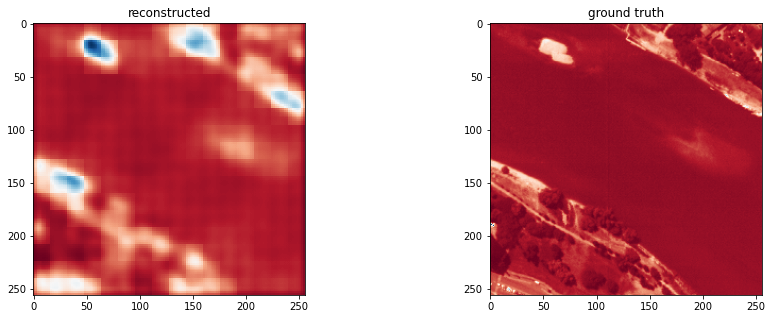

In [62]:
epochs = 2000 
w_list = []
test_loss_list = []
train_loss_list = []


for i in range(epochs): 
    print(f'Epoch: {i}')
    train_loss = 0
    
    for j, sample in enumerate(train_dataloader):   
        #pretty printing
        helper.show_progress_bar(train_dataloader, j, nl = True)
        
        # Compute the output image 
        output = model(sample['image'].to(device))   
        
        # Compute the loss
        loss = loss_function(output, sample['image'].to(device)) 
        train_loss += loss.item()
        
        # Update the model based on the loss
        optimizer.zero_grad() 
        loss.backward()  
        optimizer.step() 
        
        # Enforce a physical constraint on the parameters 
        model.model1.w_blur.data = torch.clip(model.model1.w_blur.data, .0006, 1)
        
        if j == len(train_dataloader) - 1:
            net_output_np = output.detach().cpu().numpy()[0]
            sim_meas_np = model.output1.detach().cpu().numpy()[0]
    
    train_loss_list.append(train_loss/train_data.__len__())
    
    #testing
    test_loss = 0
    if i % 10 == 0:
        test_loss, test_np, ground_truth_np = run_test()
        test_loss_list.append(test_loss)
        
        #show test recon next to ground truth
        print("\t total Test Loss (", i, "): \t", round(test_loss_list[-1], 4))
        fig,ax = plt.subplots(1,2,figsize = (15,5))
        ax[0].imshow(np.mean(test_np, 0), cmap = 'RdBu')
        ax[0].set_title('reconstructed')
        ax[1].imshow(np.mean(ground_truth_np,0), cmap = 'RdBu')
        ax[1].set_title('ground truth')
        
        plt.show()
        torch.save(model.state_dict(), save_folder + 'saved_model_' 'ep'+str(i)+'_testloss_'+str(test_loss) + '.pt')
        scipy.io.savemat(save_folder+'saved_lists.mat', 
                         {'test_loss': test_loss_list,
                         'train_loss': train_loss_list,
                         'w_list': w_list})
    test_loss_list.append(test_loss)

    #save model state
    torch.save(model.state_dict(), save_folder + 'saved_model_' 'ep'+str(i + offset)+'_testloss_'+str(test_loss) + '.pt')
    scipy.io.savemat(save_folder+'saved_lists.mat', 
                     {'test_loss': test_loss_list,
                     'train_loss': train_loss_list,
                     'w_list': w_list})

### Interpreting the Output
The model will run in the background, but the previous cell will show the results of tests as images. 

We have pretrained models, which for our purposes we can just skip to directly.

In [13]:
latest_checkpoint ="saved_models/optimal_models/saved_model_ep1130_6_testloss_0.0003215452015865594.pt"
model.load_state_dict(torch.load(latest_checkpoint))

<All keys matched successfully>

Let's apply the model to some of the inputs in our test data and take a look at the output while calculating the loss to give us quantitative verification that it is learning what it's supposed to, since hyperspectral data can be a bit hard to visualize. To help us visualize the images we can cast them in fasle color based off of what we know their original spectral channels were.

In [14]:
def get_false_color(img, k = 40, sc = [0.49,0.837,2.02]):
    img = np.transpose(img, (1,2,0))
    img = (img * 255).astype(np.uint8)
    return np.rot90(helper.stack_rgb_opt_30(img, scaling = [sc[0]*k,sc[1]*k,sc[2]*k], channels = 30), k=3)

	 testing 6/6 [==================================================>] (100%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


	 testing 6/6 [==================================================>] (100%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


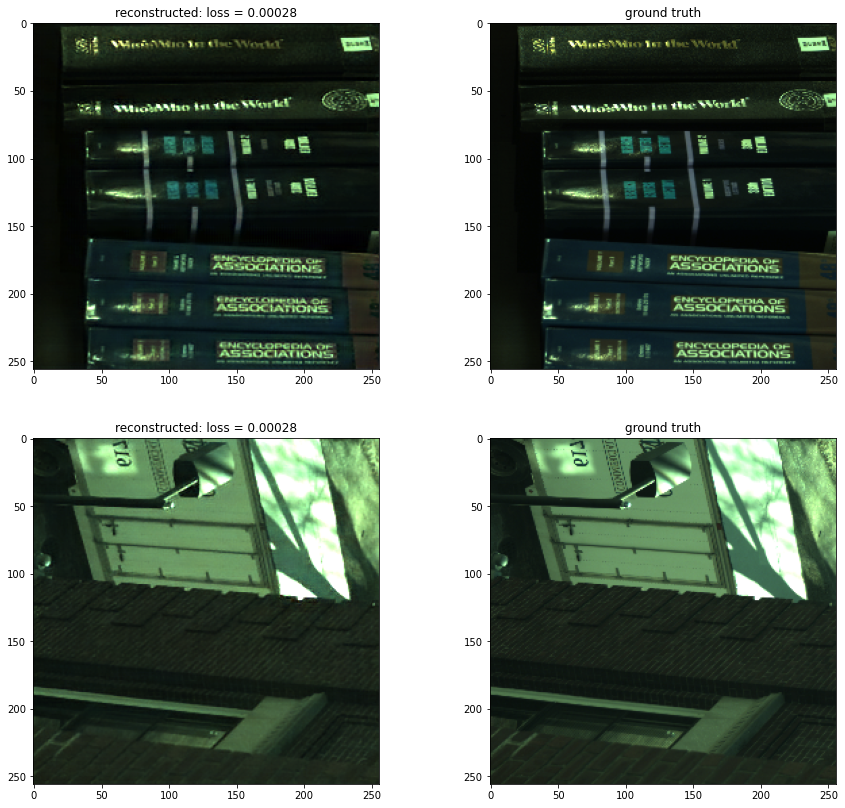

In [15]:
rows = 2
model.eval()
fig,ax = plt.subplots(rows,2,figsize = (15,7*rows))

for i in range(rows):
    test_loss, test_np, ground_truth_np = run_test(dataloader = val_dataloader)
    
    ax[i][1].imshow(get_false_color(ground_truth_np))
    ax[i][1].set_title('ground truth')
    ax[i][0].imshow(get_false_color(test_np))
    ax[i][0].set_title(f'reconstructed: loss = {test_loss:.5f}')

plt.show()

We can also validate our data by using different criterion. MSE is a very common choice for image reconstruction, but with hyperspectral images, we must weigh the spatial and spectral accuracy of each reconstruction with eachother. Lpips does a good job at calculating a visual (perceptual) loss metric.
<br>
<br>
Ideally we would use these loss metrics to compare our model with other methods. This would require a much more involved notebook, but if you plan to use DefocusCam, keep in mind that deep learning methods for high-dimensional hyperspectral data are very sensitive to spectro-spatial loss metrics.
<br> <br>
A tutorial covering the iterative methods and different forward models using Fista can be found in **dev_notebooks/spectral_diffuser_defocuscam_tutorial_iterative.ipynb**

In [16]:
def get_lpips_loss(img1, img2):
    loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
    loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization
    loss_function = MSELoss() #CosineSimilarity()
    loss_function_2 = CosineSimilarity(dim = 1)

    lpips_loss = []
    for i in range(6,7):#img1.shape[1]//3):
        a = img1[:,3*i:3*i + 3,:,:].detach().cpu()
        b = img2[:,3*i:3*i + 3,:,:].detach().cpu()
        lpips_loss.append(loss_fn_vgg(a, b).item())
    return np.mean(np.asarray(lpips_loss))

In [19]:
test_loss, test_np, ground_truth_np = run_test(dataloader = val_dataloader, loss_function = get_lpips_loss)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off])
Loading model from: /home/cfoley_waller/anaconda3/envs/defocam/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/cfoley_waller/anaconda3/envs/defocam/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


/home/cfoley_waller/anaconda3/envs/defocam/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off])
Loading model from: /home/cfoley_waller/anaconda3/envs/defocam/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/cfoley_waller/anaconda3/envs/defocam/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]%)
Loading model from: /home/cfoley_waller/anaconda3/envs/defocam/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/cfoley_waller/anaconda3/envs/defocam/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off])
Loading model from: /home/cfoley_waller/anaconda3/envs/defocam/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vg

In [20]:
print(test_loss)

0.056268113354841866


Hurray if you made it this far **!! :)**. This code is for free use, but if you plan to use any of the code, please credit the authors and cite the paper: https://opg.optica.org/abstract.cfm?uri=COSI-2022-CF2C.1 <br> <br>
*BibTex citation:* <br>
>@inproceedings{Foley:22,<br>
author = {Christian Foley and Kristina Monakhova and Kyrollos Yanny and Laura Waller},<br>
booktitle = {Imaging and Applied Optics Congress 2022 (3D, AOA, COSI, ISA, pcAOP)},<br>
journal = {Imaging and Applied Optics Congress 2022 (3D, AOA, COSI, ISA, pcAOP)},<br>
keywords = {Cameras; Hyperspectral imaging; Image quality; Medical imaging; Optical design; Spatial resolution},<br>
pages = {CF2C.1},<br>
publisher = {Optica Publishing Group},<br>
title = {Spectral DefocusCam: hyperspectral imaging using defocus and a spectral filter array},<br>
year = {2022},<br>
url = {http://opg.optica.org/abstract.cfm?URI=COSI-2022-CF2C.1},
abstract = {We propose a compact hyperspectral camera based on a focus-tunable lens and spectral filter array. The camera captures then fuses multiple defocused measurements to obtain a high-resolution hyperspectral volume.},<br>
}

<br> <br>
*Plain text citation:* <br> 
>C. Foley, K. Monakhova, K. Yanny, and L. Waller, "Spectral DefocusCam: hyperspectral imaging using defocus and a spectral filter array," in Imaging and Applied Optics Congress 2022 (3D, AOA, COSI, ISA, pcAOP), Technical Digest Series (Optica Publishing Group, 2022), paper CF2C.1.
